<a href="https://colab.research.google.com/github/benk-007/Detection_-_Recommendation_for_Grey_Sheep_User/blob/main/Mini_Batch%2BMKMeans%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SECTION 1 — Environment Setup**

## Install Required Libraries

In [1]:
# Install missing packages (safe for Colab)
!pip install --quiet numpy scipy scikit-learn tqdm
!pip install --quiet numba


## Import All Libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

print("✔ Libraries imported successfully.")


✔ Libraries imported successfully.


# **SECTION 2 — Download & Load MovieLens**

## Download MovieLens

In [3]:
# Download and unzip MovieLens 1M dataset
!wget -q --show-progress https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -q ml-1m.zip

print("✔ MovieLens 1M downloaded and extracted successfully.")


ml-1m.zip           100%[===================>]   5.64M  11.0MB/s    in 0.5s    
✔ MovieLens 1M downloaded and extracted successfully.


## Load Ratings & Movies

In [4]:
# Load ratings.dat
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["userId", "movieId", "rating", "timestamp"],
    usecols=[0, 1, 2],        # we don't need timestamp
    engine="python",
    dtype={"userId": "int32", "movieId": "int32", "rating": "float32"}
)

# Load movies.dat
movies = pd.read_csv(
    "ml-1m/movies.dat",
    sep="::",
    names=["movieId", "title", "genres"],
    engine="python",
    encoding="latin-1",
    dtype={"movieId": "int32"}
)


print("Ratings shape:", ratings.shape)
print("Movies shape :", movies.shape)
ratings.head()


Ratings shape: (1000209, 3)
Movies shape : (3883, 3)


,userId,movieId,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


## Encode userId & movieId to index values

In [5]:
# Convert userId and movieId to sequential indices
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings["user_idx"] = user_encoder.fit_transform(ratings["userId"])
ratings["movie_idx"] = movie_encoder.fit_transform(ratings["movieId"])

n_users  = ratings["user_idx"].nunique()
n_movies = ratings["movie_idx"].nunique()

print("Total users :", n_users)
print("Total movies:", n_movies)
ratings.head()


Total users : 6040
Total movies: 3706


,userId,movieId,rating,user_idx,movie_idx
0,1,1193,5.0,0,1104
1,1,661,3.0,0,639
2,1,914,3.0,0,853
3,1,3408,4.0,0,3177
4,1,2355,5.0,0,2162


## Create the Sparse User–Movie Matrix

In [6]:
# Build the sparse matrix (CSR format)
X = csr_matrix(
    (ratings["rating"], (ratings["user_idx"], ratings["movie_idx"])),
    shape=(n_users, n_movies),
    dtype=np.float32
)

X


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1000209 stored elements and shape (6040, 3706)>

## Compute Power User & Power Item

In [7]:
# Number of ratings per user
user_counts = np.bincount(ratings["user_idx"], minlength=n_users)

# Number of ratings per movie
movie_counts = np.bincount(ratings["movie_idx"], minlength=n_movies)

# --- Power User (activity weight) ---
power_user = np.log1p(user_counts)
power_user = power_user / power_user.max()

# --- Power Item (rarity weight) ---
power_item = 1 / np.log1p(movie_counts)
power_item = power_item / power_item.max()

print("✔ Power User & Power Item computed.")


✔ Power User & Power Item computed.


# **SECTION 3 — MKMeans++ with Mini-Batch Support and Find Best K**

## Utility distance functions

In [8]:
# ============================
#  Weighted distance functions
# ============================

def weighted_euclidean_sparse(X_batch, centroids, power_user_batch, power_item):
    """
    Compute weighted Euclidean distance between a batch of sparse users and all centroids.

    X_batch:     csr matrix (batch_size × n_movies)
    centroids:   np.ndarray (k × n_movies)
    power_user_batch: (batch_size,)
    power_item:  (n_movies,)
    """
    # Apply item weights to centroids (broadcast)
    weighted_centroids = centroids * power_item

    # Compute differences (sparse)
    # For X_batch: weights apply to each movie column
    X_w = X_batch.multiply(power_item)

    # Compute squared norms using sparse algebra
    # ||x - c||^2 = ||x||^2 + ||c||^2 - 2 * <x, c>
    x_norm = np.array(X_w.power(2).sum(axis=1)).flatten()
    c_norm = np.sum(weighted_centroids ** 2, axis=1)

    # Dot product: X_w * centroid.T
    dot = X_w.dot(weighted_centroids.T)

    # Final distance matrix
    distances = np.sqrt(x_norm[:, None] + c_norm[None, :] - 2 * dot)

    # Apply user weights (low-activity users get amplified)
    distances *= (1 + (1 - power_user_batch)[:, None])

    return distances


## MKMeans++ initialization (mini-batch)

In [9]:
# ==========================================
#  MKMeans++ Initialization (Mini-Batch)
# ==========================================

def mkmeanspp_init(X, k, batch_size, power_user, power_item):
    """
    Weighted MKMeans++ initialization with mini-batch sampling.
    Returns initial centroids as dense numpy array.
    """
    n_users, n_movies = X.shape

    # Step 1 — pick first centroid randomly
    first_idx = np.random.randint(0, n_users)
    centroids = [X[first_idx].toarray().flatten()]

    print("✔ First centroid initialized.")

    # Step 2 — choose remaining k-1 centroids
    for _ in range(1, k):

        # Sample a mini-batch of users
        batch_idx = np.random.choice(n_users, size=batch_size, replace=False)
        X_batch = X[batch_idx]
        power_user_batch = power_user[batch_idx]

        # Compute distances to current centroids
        dists = weighted_euclidean_sparse(
            X_batch,
            np.array(centroids),
            power_user_batch,
            power_item
        )

        # Get min distance to any centroid
        min_dist = np.min(dists, axis=1)

        # ------------------------------
        # FIX: Safe probability handling
        # ------------------------------
        probs = min_dist ** 2
        total = probs.sum()

        if total == 0 or np.isnan(total) or np.isinf(total):
            # Fallback: choose a random user from the batch
            chosen = np.random.choice(batch_idx)
            print("⚠ Zero or NaN distances detected → random centroid selected.")
        else:
            probs = probs / total
            chosen = np.random.choice(batch_idx, p=probs)

        centroids.append(X[chosen].toarray().flatten())

        print(f"✔ Chosen centroid {_+1}/{k}")

    return np.array(centroids)


## MiniBatchMKMeansPP main class

In [10]:
# =======================================
#   Mini-Batch MKMeans++ (FULL CLASS)
# =======================================

class MiniBatchMKMeansPP:
    def __init__(self, n_clusters=8, batch_size=2048, max_iter=50,
                 power_user=None, power_item=None):

        self.k = n_clusters
        self.batch_size = batch_size
        self.max_iter = max_iter

        self.power_user = power_user
        self.power_item = power_item

        self.centroids = None
        self.labels_ = None

    # -------------------------------
    # 1) FIT
    # -------------------------------
    def fit(self, X):
        n_users = X.shape[0]
        print("🔵 Initializing MKMeans++ centroids...")

        # Step A — MKMeans++ initialization
        self.centroids = mkmeanspp_init(
            X,
            self.k,
            self.batch_size,
            self.power_user,
            self.power_item
        )

        print("🔵 Starting Mini-Batch iterations...\n")

        # Step B — Iterative mini-batch updates
        for it in range(self.max_iter):
            batch_idx = np.random.choice(n_users, size=self.batch_size, replace=False)
            X_batch = X[batch_idx]
            power_user_batch = self.power_user[batch_idx]

            # Compute distances
            dists = weighted_euclidean_sparse(
                X_batch, self.centroids, power_user_batch, self.power_item
            )

            # Find nearest centroid for each user
            nearest = np.argmin(dists, axis=1)

            # Update centroids (online update)
            for j in range(self.k):
                mask = (nearest == j)
                if mask.sum() > 0:
                    # mean update of users in this batch
                    batch_points = X_batch[mask].mean(axis=0)
                    self.centroids[j] = 0.7 * self.centroids[j] + 0.3 * np.array(batch_points).flatten()

            print(f"✔ Iteration {it+1}/{self.max_iter} done.")

        print("\n🟢 MKMeans++ training complete.")

    # -------------------------------
    # 2) PREDICT LABELS
    # -------------------------------
    def predict(self, X):
        n_users = X.shape[0]
        labels = np.zeros(n_users, dtype=int)

        for start in range(0, n_users, self.batch_size):
            end = min(start + self.batch_size, n_users)
            X_batch = X[start:end]
            power_user_batch = self.power_user[start:end]

            dists = weighted_euclidean_sparse(
                X_batch, self.centroids, power_user_batch, self.power_item
            )

            labels[start:end] = np.argmin(dists, axis=1)

        return labels


## Elbow Method

In [11]:
Ks = [5, 8, 10, 12, 14, 16, 18, 20]
inertias = []

print("🔎 Running Elbow search...")

for k in Ks:
    print(f"\n⏳ Training MKMeans++ for K={k}")

    mk_tmp = MiniBatchMKMeansPP(
        n_clusters=k,
        batch_size=2048,
        max_iter=15,        # fewer iterations for speed
        power_user=power_user,
        power_item=power_item
    )

    mk_tmp.fit(X)

    # Compute inertia on a random sample
    sample_idx = np.random.choice(n_users, size=1500, replace=False)
    X_sample = X[sample_idx]
    pu_sample = power_user[sample_idx]

    dists = weighted_euclidean_sparse(
        X_sample, mk_tmp.centroids, pu_sample, power_item
    )
    inertia = np.min(dists, axis=1).sum()
    inertias.append(inertia)

print("\n✔ Elbow search complete.")


🔎 Running Elbow search...

⏳ Training MKMeans++ for K=5
🔵 Initializing MKMeans++ centroids...
✔ First centroid initialized.
✔ Chosen centroid 2/5
✔ Chosen centroid 3/5
✔ Chosen centroid 4/5
✔ Chosen centroid 5/5
🔵 Starting Mini-Batch iterations...

✔ Iteration 1/15 done.
✔ Iteration 2/15 done.
✔ Iteration 3/15 done.
✔ Iteration 4/15 done.
✔ Iteration 5/15 done.
✔ Iteration 6/15 done.
✔ Iteration 7/15 done.
✔ Iteration 8/15 done.
✔ Iteration 9/15 done.
✔ Iteration 10/15 done.
✔ Iteration 11/15 done.
✔ Iteration 12/15 done.
✔ Iteration 13/15 done.
✔ Iteration 14/15 done.
✔ Iteration 15/15 done.

🟢 MKMeans++ training complete.

⏳ Training MKMeans++ for K=8
🔵 Initializing MKMeans++ centroids...
✔ First centroid initialized.
⚠ Zero or NaN distances detected → random centroid selected.
✔ Chosen centroid 2/8
⚠ Zero or NaN distances detected → random centroid selected.
✔ Chosen centroid 3/8
⚠ Zero or NaN distances detected → random centroid selected.
✔ Chosen centroid 4/8
✔ Chosen centroid 5/8

## Plot Elbow Curve

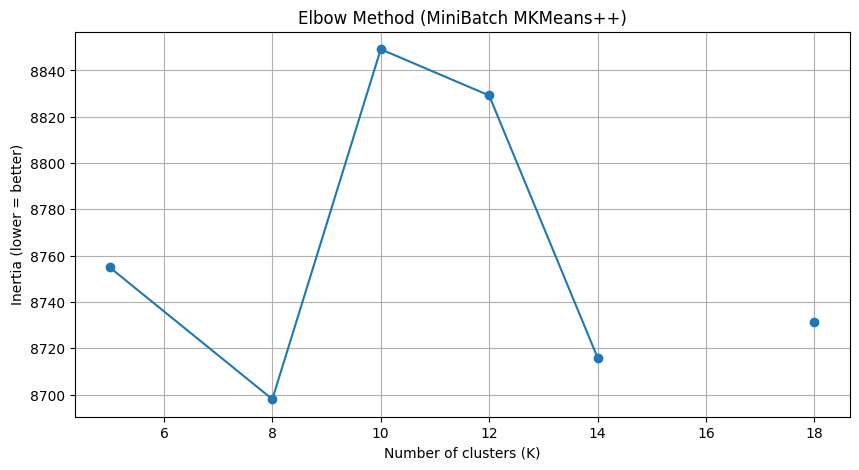

In [12]:
plt.figure(figsize=(10,5))
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow Method (MiniBatch MKMeans++)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (lower = better)")
plt.grid(True)
plt.show()

## Silhouette Score

In [13]:
from sklearn.metrics import silhouette_score

Ks = [5, 8, 10, 12, 14]

sil_scores = []

sample_idx = np.random.choice(n_users, size=2000, replace=False)
X_sample = X[sample_idx]
pu_sample = power_user[sample_idx]

print("🔎 Running Silhouette analysis...")

for k in Ks:
    print(f"\n⏳ Training MKMeans++ for K={k}")

    mk_tmp = MiniBatchMKMeansPP(
        n_clusters=k,
        batch_size=2048,
        max_iter=20,
        power_user=power_user,
        power_item=power_item
    )
    mk_tmp.fit(X)

    labels_tmp = mk_tmp.predict(X_sample)

    # Cosine-based silhouette
    sil = silhouette_score(X_sample, labels_tmp, metric="cosine")
    sil_scores.append(sil)
    print(f"✔ Silhouette for K={k}: {sil:.4f}")


🔎 Running Silhouette analysis...

⏳ Training MKMeans++ for K=5
🔵 Initializing MKMeans++ centroids...
✔ First centroid initialized.
✔ Chosen centroid 2/5
⚠ Zero or NaN distances detected → random centroid selected.
✔ Chosen centroid 3/5
✔ Chosen centroid 4/5
✔ Chosen centroid 5/5
🔵 Starting Mini-Batch iterations...

✔ Iteration 1/20 done.
✔ Iteration 2/20 done.
✔ Iteration 3/20 done.
✔ Iteration 4/20 done.
✔ Iteration 5/20 done.
✔ Iteration 6/20 done.
✔ Iteration 7/20 done.
✔ Iteration 8/20 done.
✔ Iteration 9/20 done.
✔ Iteration 10/20 done.
✔ Iteration 11/20 done.
✔ Iteration 12/20 done.
✔ Iteration 13/20 done.
✔ Iteration 14/20 done.
✔ Iteration 15/20 done.
✔ Iteration 16/20 done.
✔ Iteration 17/20 done.
✔ Iteration 18/20 done.
✔ Iteration 19/20 done.
✔ Iteration 20/20 done.

🟢 MKMeans++ training complete.
✔ Silhouette for K=5: -0.0607

⏳ Training MKMeans++ for K=8
🔵 Initializing MKMeans++ centroids...
✔ First centroid initialized.
✔ Chosen centroid 2/8
✔ Chosen centroid 3/8
⚠ Zero o

## Plot Silhouette Curve

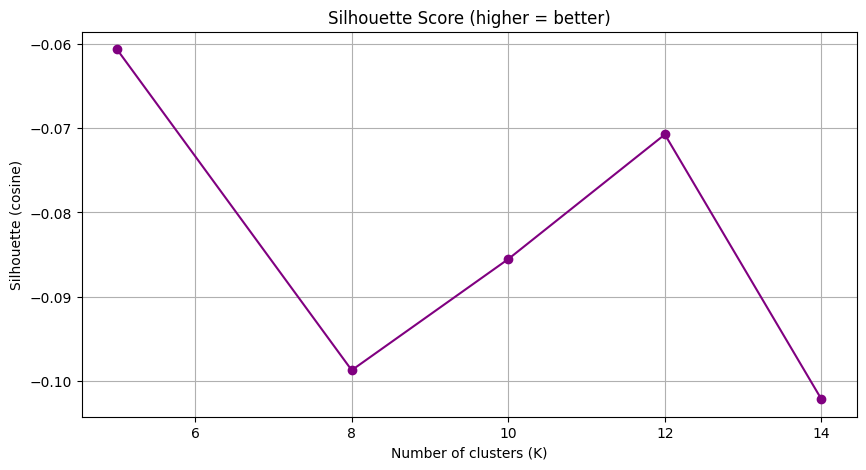

In [14]:
plt.figure(figsize=(10,5))
plt.plot(Ks, sil_scores, marker='o', color='purple')
plt.title("Silhouette Score (higher = better)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette (cosine)")
plt.grid(True)
plt.show()

## **SECTION 4 — Train MKMeans++ on MovieLens 1M + Assign Clusters**

## Choose Hyperparameters

In [15]:
# Use the optimal K from Section 3
K = 10   # selected based on Elbow + Silhouette

BATCH_SIZE = 2048   # suitable for ML-1M
MAX_ITER = 35       # enough for convergence

print(f"🔵 Final MKMeans++ config ➜ K={K}, batch={BATCH_SIZE}, iter={MAX_ITER}")


🔵 Final MKMeans++ config ➜ K=10, batch=2048, iter=35


## Train MKMeans++

In [16]:
# Train the final MKMeans++ model
mk = MiniBatchMKMeansPP(
    n_clusters=K,
    batch_size=BATCH_SIZE,
    max_iter=MAX_ITER,
    power_user=power_user,
    power_item=power_item
)

print("🚀 Training MKMeans++ on full MovieLens-1M...")

t0 = time.time()
mk.fit(X)
t1 = time.time()

print(f"\n🟢 Training complete in {t1 - t0:.2f} seconds.")


🚀 Training MKMeans++ on full MovieLens-1M...
🔵 Initializing MKMeans++ centroids...
✔ First centroid initialized.
✔ Chosen centroid 2/10
✔ Chosen centroid 3/10
✔ Chosen centroid 4/10
⚠ Zero or NaN distances detected → random centroid selected.
✔ Chosen centroid 5/10
✔ Chosen centroid 6/10
✔ Chosen centroid 7/10
✔ Chosen centroid 8/10
✔ Chosen centroid 9/10
✔ Chosen centroid 10/10
🔵 Starting Mini-Batch iterations...

✔ Iteration 1/35 done.
✔ Iteration 2/35 done.
✔ Iteration 3/35 done.
✔ Iteration 4/35 done.
✔ Iteration 5/35 done.
✔ Iteration 6/35 done.
✔ Iteration 7/35 done.
✔ Iteration 8/35 done.
✔ Iteration 9/35 done.
✔ Iteration 10/35 done.
✔ Iteration 11/35 done.
✔ Iteration 12/35 done.
✔ Iteration 13/35 done.
✔ Iteration 14/35 done.
✔ Iteration 15/35 done.
✔ Iteration 16/35 done.
✔ Iteration 17/35 done.
✔ Iteration 18/35 done.
✔ Iteration 19/35 done.
✔ Iteration 20/35 done.
✔ Iteration 21/35 done.
✔ Iteration 22/35 done.
✔ Iteration 23/35 done.
✔ Iteration 24/35 done.
✔ Iteration 25

## Predict cluster labels for all users

In [17]:
# Predict clusters for all users
labels = mk.predict(X)

print("Labels shape:", labels.shape)
print("Clusters found:", np.unique(labels))


Labels shape: (6040,)
Clusters found: [0 1 2 3 4 5 6 7 8 9]


## Build results DataFrame

In [18]:
# Build a DataFrame with all user information
results_df = pd.DataFrame({
    "user_idx": np.arange(n_users),
    "cluster": labels,
    "power_user": power_user,
})

results_df.head()


,user_idx,cluster,power_user
0,0,5,0.514896
1,1,1,0.628299
2,2,5,0.510024
3,3,5,0.398990
4,4,0,0.683257


## Visualize cluster distribution

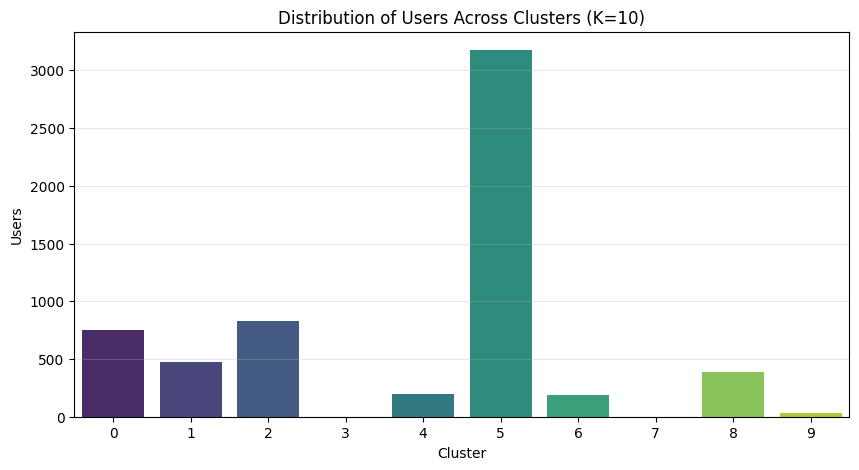

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x=results_df["cluster"], palette="viridis")
plt.title("Distribution of Users Across Clusters (K=10)")
plt.xlabel("Cluster")
plt.ylabel("Users")
plt.grid(axis='y', alpha=0.3)
plt.show()

# **SECTION 5 — Grey Sheep Detection (Similarity + Distance + Consensus)**

## Compute Centroid Matrix

In [20]:
# Extract centroids as dense matrix
centroids = mk.centroids.copy()

print("Centroids shape:", centroids.shape)


Centroids shape: (10, 3706)


## Compute Cosine Similarity User ↔ Centroid

In [21]:
# Prepare similarity array
similarity_scores = np.zeros(n_users, dtype=np.float32)

print("🔍 Computing cosine similarity for users...")

for i in range(0, n_users, 1024):  # batch to avoid RAM issues
    end = min(i + 1024, n_users)
    X_batch = X[i:end].toarray()  # safe for ML-1M
    batch_labels = labels[i:end]

    # compute one centroid per user
    batch_centroids = centroids[batch_labels]

    # cosine similarity row-wise
    sim = np.sum(X_batch * batch_centroids, axis=1) / (
        np.linalg.norm(X_batch, axis=1) * np.linalg.norm(batch_centroids, axis=1) + 1e-10
    )

    similarity_scores[i:end] = sim

print("✔ Cosine similarity computed.")


🔍 Computing cosine similarity for users...
✔ Cosine similarity computed.


## Compute Weighted Euclidean Distance

In [22]:
print("🔍 Computing weighted Euclidean distances...")

distance_scores = np.zeros(n_users, dtype=np.float32)

for i in range(0, n_users, 2048):
    end = min(i + 2048, n_users)

    X_batch = X[i:end]
    pu_batch = power_user[i:end]
    batch_centroids = centroids[labels[i:end]]

    # Use our custom distance function
    d = weighted_euclidean_sparse(X_batch, batch_centroids, pu_batch, power_item)

    # each user has 1 centroid-distance
    distance_scores[i:end] = d.diagonal()

print("✔ Distance computation complete.")


🔍 Computing weighted Euclidean distances...
✔ Distance computation complete.


## Add Metrics to DataFrame

In [23]:
results_df["similarity"] = similarity_scores
results_df["distance"] = distance_scores

results_df.head()

,user_idx,cluster,power_user,similarity,distance
0,0,5,0.514896,0.334982,4.565489
1,1,1,0.628299,0.443921,6.041249
2,2,5,0.510024,0.348757,4.071052
3,3,5,0.398990,0.252158,3.026318
4,4,0,0.683257,0.391440,7.078339


## Define Thresholds for Grey Sheep

In [24]:
# Cosine similarity threshold (omega)
omega = results_df["similarity"].quantile(0.20)

# Distance threshold (tau)
tau = results_df["distance"].quantile(0.80)

# Grey sheep detection
grey_sim  = results_df["similarity"] < omega
grey_dist = results_df["distance"] > tau

# Consensus : OR (union) or AND (intersection)
results_df["is_grey_sheep"] = grey_sim | grey_dist   # recommended


## Print Statistics

In [25]:
total = len(results_df)
grey = results_df["is_grey_sheep"].sum()
white = total - grey

print("📊 GREY SHEEP ANALYSIS")
print("="*50)
print(f"Total users:        {total}")
print(f"Grey sheep:         {grey}  ({grey/total*100:.1f}%)")
print(f"White users:        {white}  ({white/total*100:.1f}%)")
print("\nThresholds:")
print(f"  Similarity ω  = {omega:.4f}")
print(f"  Distance τ    = {tau:.4f}")

📊 GREY SHEEP ANALYSIS
Total users:        6040
Grey sheep:         2391  (39.6%)
White users:        3649  (60.4%)

Thresholds:
  Similarity ω  = 0.2454
  Distance τ    = 7.6458


## Visualize Distributions

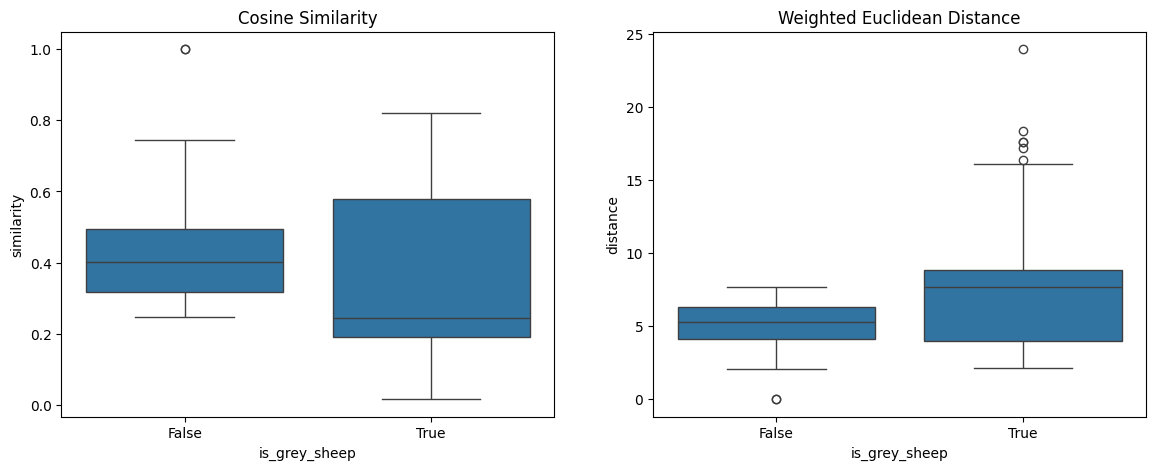

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.boxplot(data=results_df, x="is_grey_sheep", y="similarity", ax=axes[0])
axes[0].set_title("Cosine Similarity")

sns.boxplot(data=results_df, x="is_grey_sheep", y="distance", ax=axes[1])
axes[1].set_title("Weighted Euclidean Distance")

plt.show()

# **SECTION 6 — Re-Clustering Only Grey Sheep Users**

## Extract Grey Sheep Users

In [27]:
# Extract grey sheep user indices
grey_idx = results_df[results_df["is_grey_sheep"]].index.values

print("Total grey sheep users:", len(grey_idx))

# Extract their vectors
X_grey = X[grey_idx]
pu_grey = power_user[grey_idx]

print("Shape of grey sheep matrix:", X_grey.shape)


Total grey sheep users: 2391
Shape of grey sheep matrix: (2391, 3706)


## Choose K for Grey Sheep Sub-Clusters

In [28]:
K_grey = 5   # number of subclusters for grey sheep

print("Re-clustering grey sheep with K =", K_grey)

Re-clustering grey sheep with K = 5


## Re-Cluster Grey Sheep with MKMeans++

In [29]:
mk_grey = MiniBatchMKMeansPP(
    n_clusters=K_grey,
    batch_size=1024,
    max_iter=40,   # slightly more iterations for better separation
    power_user=pu_grey,
    power_item=power_item
)

print("🚀 Training MKMeans++ on grey sheep only...")

t0 = time.time()
mk_grey.fit(X_grey)
t1 = time.time()

print(f"\n🟢 Grey sheep re-clustering complete in {t1 - t0:.2f} seconds.")

🚀 Training MKMeans++ on grey sheep only...
🔵 Initializing MKMeans++ centroids...
✔ First centroid initialized.
⚠ Zero or NaN distances detected → random centroid selected.
✔ Chosen centroid 2/5
✔ Chosen centroid 3/5
✔ Chosen centroid 4/5
✔ Chosen centroid 5/5
🔵 Starting Mini-Batch iterations...

✔ Iteration 1/40 done.
✔ Iteration 2/40 done.
✔ Iteration 3/40 done.
✔ Iteration 4/40 done.
✔ Iteration 5/40 done.
✔ Iteration 6/40 done.
✔ Iteration 7/40 done.
✔ Iteration 8/40 done.
✔ Iteration 9/40 done.
✔ Iteration 10/40 done.
✔ Iteration 11/40 done.
✔ Iteration 12/40 done.
✔ Iteration 13/40 done.
✔ Iteration 14/40 done.
✔ Iteration 15/40 done.
✔ Iteration 16/40 done.
✔ Iteration 17/40 done.
✔ Iteration 18/40 done.
✔ Iteration 19/40 done.
✔ Iteration 20/40 done.
✔ Iteration 21/40 done.
✔ Iteration 22/40 done.
✔ Iteration 23/40 done.
✔ Iteration 24/40 done.
✔ Iteration 25/40 done.
✔ Iteration 26/40 done.
✔ Iteration 27/40 done.
✔ Iteration 28/40 done.
✔ Iteration 29/40 done.
✔ Iteration 30/4

## Predict Grey Sheep Subcluster Labels

In [30]:
labels_grey = mk_grey.predict(X_grey)

print("Unique grey sheep subclusters:", np.unique(labels_grey))

Unique grey sheep subclusters: [0 1 2 3 4]


## Add Subcluster to Main DataFrame

In [31]:
# Initialize the column
results_df["grey_cluster"] = -1

# Insert labels
results_df.loc[grey_idx, "grey_cluster"] = labels_grey

results_df.head()


,user_idx,cluster,power_user,similarity,distance,is_grey_sheep,grey_cluster
0,0,5,0.514896,0.334982,4.565489,False,-1
1,1,1,0.628299,0.443921,6.041249,False,-1
2,2,5,0.510024,0.348757,4.071052,False,-1
3,3,5,0.398990,0.252158,3.026318,False,-1
4,4,0,0.683257,0.391440,7.078339,False,-1


## Visualize Size of Grey Sheep Sub-Clusters

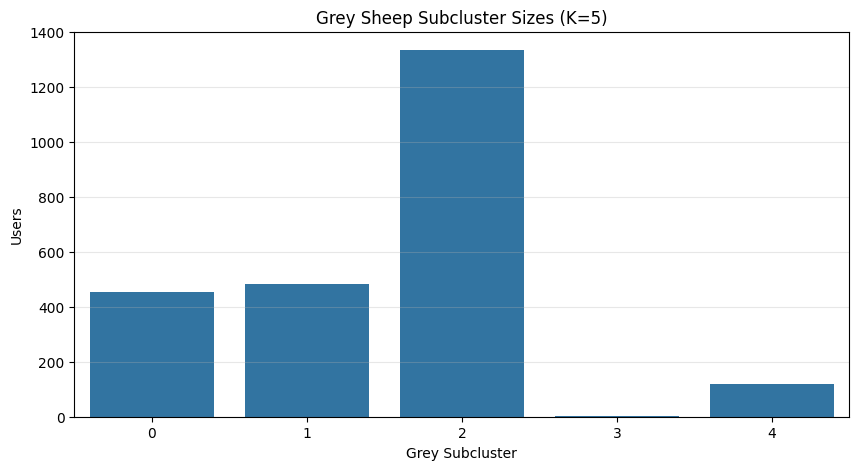

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(x=results_df[results_df["is_grey_sheep"]]["grey_cluster"])
plt.title("Grey Sheep Subcluster Sizes (K=5)")
plt.xlabel("Grey Subcluster")
plt.ylabel("Users")
plt.grid(axis='y', alpha=0.3)
plt.show()

## Compare Metrics Between Grey Subclusters

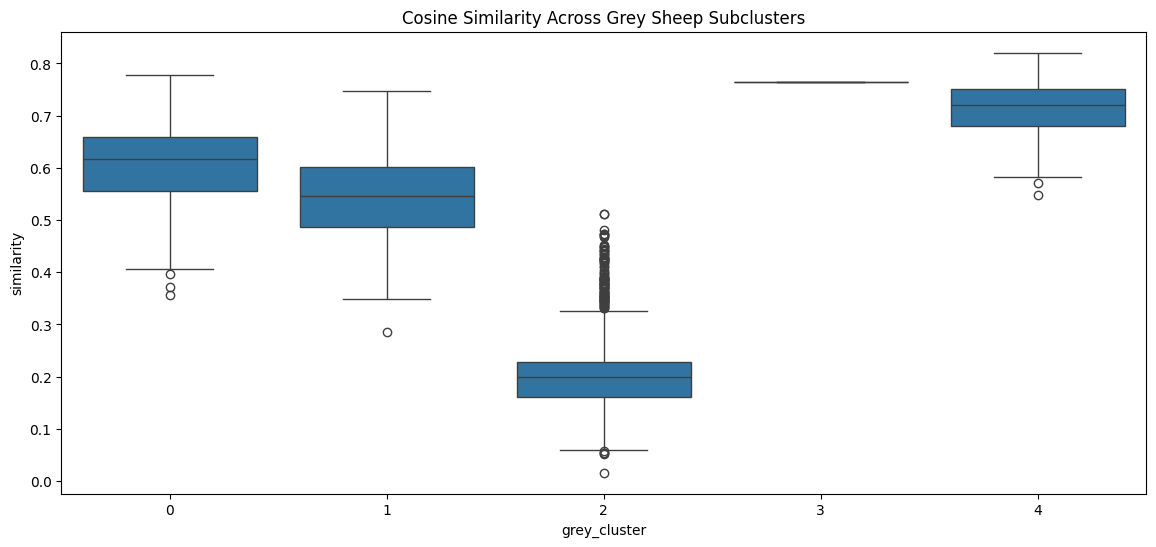

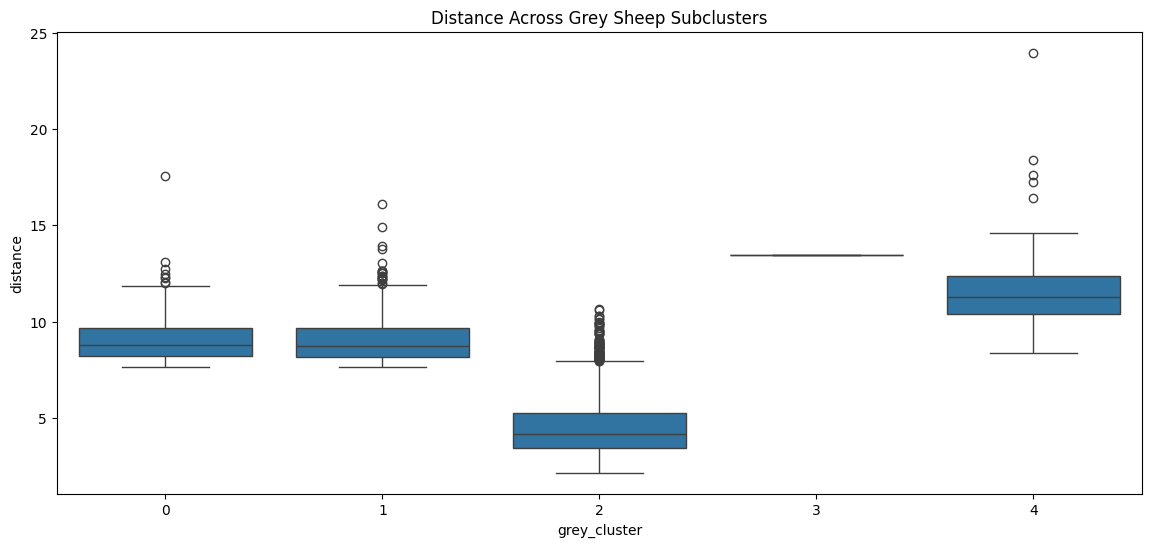

In [33]:
plt.figure(figsize=(14,6))
sns.boxplot(data=results_df[results_df["is_grey_sheep"]],
            x="grey_cluster", y="similarity")
plt.title("Cosine Similarity Across Grey Sheep Subclusters")
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(data=results_df[results_df["is_grey_sheep"]],
            x="grey_cluster", y="distance")
plt.title("Distance Across Grey Sheep Subclusters")
plt.show()

# **SECTION 7 — Personalized Recommendations for Grey & White Users**

## Load Movie Titles

In [34]:
movies.head()
print(movies.columns)


Index(['movieId', 'title', 'genres'], dtype='object')


In [35]:
movies_df = movies.copy()
movies_df = movies_df.set_index("movieId")

print("Movies loaded:", len(movies_df))
movies_df.head()

Movies loaded: 3883


,title,genres
movieId,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


## Helper Function to Recommend Top Movies from a Cluster

In [36]:
# Build mapping: movie_idx → movieId (MovieLens ID)
movie_ids = movie_encoder.inverse_transform(np.arange(n_movies))

print("✔ movie_ids mapping ready. Example:")
print(movie_ids[:10])


✔ movie_ids mapping ready. Example:
[ 1  2  3  4  5  6  7  8  9 10]


In [37]:
def recommend_from_centroid(user_id, N=10):
    """
    Recommend N movies for a given user based on their cluster centroid.
    """
    user_vector = X[user_id].toarray().flatten()
    user_cluster = results_df.loc[user_id, "cluster"]

    # get that cluster's centroid
    centroid = centroids[user_cluster]

    # sort movies by centroid score descending
    movie_scores = list(enumerate(centroid))
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)

    # filter movies already rated by this user
    seen = set(np.where(user_vector > 0)[0])

    recs = []
    for movie_id, score in movie_scores:
        if movie_id not in seen:
            recs.append((movie_id, score))
        if len(recs) >= N:
            break

    # map back to movie titles
    rec_df = pd.DataFrame(recs, columns=["movie_idx", "score"])
    rec_df["movie_id"] = movie_ids[rec_df["movie_idx"]]
    rec_df["title"] = rec_df["movie_id"].apply(lambda mid: movies_df.loc[mid, "title"])

    return rec_df[["movie_id", "title", "score"]]

## Recommend for a White User

In [38]:
white_users = results_df[~results_df["is_grey_sheep"]].index.values
test_white = np.random.choice(white_users)

print(f"🎬 Recommendations for WHITE user {test_white}:")
recommend_from_centroid(test_white, N=10)

🎬 Recommendations for WHITE user 2232:


,movie_id,title,score
0,527,Schindler's List (1993),2.906760
1,1617,L.A. Confidential (1997),2.859385
2,858,"Godfather, The (1972)",2.818373
3,296,Pulp Fiction (1994),2.747088
4,2396,Shakespeare in Love (1998),2.704663
5,2997,Being John Malkovich (1999),2.598033
6,260,Star Wars: Episode IV - A New Hope (1977),2.561239
7,1198,Raiders of the Lost Ark (1981),2.414020
8,1230,Annie Hall (1977),2.344230
9,1247,"Graduate, The (1967)",2.327214


## Grey Subcluster Recommendations (More Accurate)

In [39]:
def recommend_from_grey_subcluster(user_id, N=10):
    if not results_df.loc[user_id, "is_grey_sheep"]:
        raise ValueError("This function is for grey sheep users only.")

    grey_c = results_df.loc[user_id, "grey_cluster"]

    subcentroid = mk_grey.centroids[grey_c]
    user_vector = X[user_id].toarray().flatten()

    # sort movies
    movie_scores = list(enumerate(subcentroid))
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)

    seen = set(np.where(user_vector > 0)[0])
    recs = []

    for movie_idx, score in movie_scores:
        if movie_idx not in seen:
            recs.append((movie_idx, score))
        if len(recs) >= N:
            break

    rec_df = pd.DataFrame(recs, columns=["movie_idx", "score"])
    rec_df["movie_id"] = movie_ids[rec_df["movie_idx"]]
    rec_df["title"] = rec_df["movie_id"].apply(lambda mid: movies_df.loc[mid, "title"])

    return rec_df[["movie_id", "title", "score"]]


## Test Grey Subcluster Recommendation

In [40]:
# Pick a random grey sheep user
grey_users = results_df[results_df["is_grey_sheep"]].index.values
test_grey = np.random.choice(grey_users)

print("Selected GREY user:", test_grey)


Selected GREY user: 1456


In [41]:
print(f"🎯 GREY user {test_grey} — Subcluster Recommendations:")
recommend_from_grey_subcluster(test_grey, 10)


🎯 GREY user 1456 — Subcluster Recommendations:


,movie_id,title,score
0,919,"Wizard of Oz, The (1939)",2.932948
1,1198,Raiders of the Lost Ark (1981),2.931423
2,750,Dr. Strangelove or: How I Learned to Stop Worr...,2.923331
3,1230,Annie Hall (1977),2.849738
4,1097,E.T. the Extra-Terrestrial (1982),2.775943
5,1270,Back to the Future (1985),2.757932
6,1252,Chinatown (1974),2.754962
7,908,North by Northwest (1959),2.687363
8,923,Citizen Kane (1941),2.687289
9,541,Blade Runner (1982),2.569612
